In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial import ConvexHull
from shapely.geometry import Point, MultiPoint, Polygon, LineString, GeometryCollection
from itertools import combinations
from matplotlib.patches import Polygon

def ZTukeyMed(X, i, plot):
    """
    X: nx2 matrix 
    i: index of z
    plot: boolean, plot == True: generates plot. plot == false: no plot, just returns depth and z-median vertices
 
    """
    z = X[i]
    n = len(X)
    upper_klevels = []
    lower_klevels = []
    candidate_constraints = []
    
    indices = range(n)
    epsilon = 1e-9
    
    # Compute all k-levels
    for idx1, idx2 in combinations(indices, 2):
        p1 = X[idx1]
        p2 = X[idx2]
        dy = p2[1] - p1[1]
        dx = p2[0] - p1[0]
        a = -dy
        b = dx
        c = - (a * p1[0] + b * p1[1])
        
        # Check how many points above/below line
        vals = a * X[:, 0] + b * X[:, 1] + c
        
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        # Evaluate z position
        z_val = a * z[0] + b * z[1] + c
        z_is_above = z_val > epsilon
        z_is_below = z_val < -epsilon
        z_on_line  = abs(z_val) <= epsilon
        
        # Case 1: Less points above, keep lower halfspace
        if n_above < n_below:
            k = n_above
            if z_is_below or z_on_line:
                candidate_constraints.append((k, a, b, c, 0))
                if k == n/2-1:
                    upper_klevels.append(["num above: ", n_above, "p1: ", p1, " p2: ", p2])

        # Case 2: fewer points below, keep upper halfspace
        elif n_below < n_above:
            k = n_below
            if z_is_above or z_on_line:
                candidate_constraints.append((k, -a, -b, -c, 0))
                if k == n/2-1:
                    lower_klevels.append(["num below: ", n_below, "p1: ", p1, " p2: ", p2])

        # Case 3: Equal number above and below
        else:
            k = n_above
            if z_is_above:
                candidate_constraints.append((k, -a, -b, -c, 0))
            elif z_is_below:
                candidate_constraints.append((k, a, b, c, 0))
            else:
                # d=1: Intersect with line itself
                if (n%2 == 0):
                    candidate_constraints.append((k, a, b, c, 1)) 

    if not candidate_constraints:
        print("No valid constraints found.")
        return 0, np.array([]), [], []

    # find median depth
    max_k = max(item[0] for item in candidate_constraints)
    median_found = False
    final_poly = np.array([]) 

    while (not median_found) and (max_k >= 0):
        active_constraints = [item for item in candidate_constraints if item[0] <= max_k]
        
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        def clip_polygon(poly, a, b, c, d):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            # d=1: Intersect with line ax+by+c=0
            if d == 1:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # If point is on the line, keep it
                    if abs(val_curr) <= 1e-9:
                        new_poly.append(p_curr)
                        
                    # If edge crosses the line (strict crossing), add intersection
                    if (val_curr < -1e-9 and val_next > 1e-9) or \
                       (val_curr > 1e-9 and val_next < -1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

            # d=0: Clip against halfspace ax+by+c <= 0
            else:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # Keep points inside
                    if val_curr <= 1e-9:
                        new_poly.append(p_curr)
                    # Add intersection if crossing boundary
                    if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)
    
        # Apply constraints
        for _, a, b, c, d in active_constraints:
            if a == 0 and b == 0: continue
            poly = clip_polygon(poly, a, b, c, d)
            if len(poly) == 0: break 
        
        if len(poly) > 0:
            min_x, max_x = np.min(poly[:,0]), np.max(poly[:,0])
            min_y, max_y = np.min(poly[:,1]), np.max(poly[:,1])
            
            width = max_x - min_x
            height = max_y - min_y
            
            is_singular = (width < 1e-6) and (height < 1e-6)
            
            if not is_singular:
                median_found = True
                final_poly = poly
            else:
                max_k -= 1
        else:
            max_k -= 1

    # --- PLOTTING ---
    if (plot):
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:,0], X[:,1], c='blue', alpha=0.6, label='Neighbors')
        plt.scatter(z[0], z[1], c='red', marker='*', s=200, zorder=10, label='Agent z')
        
        if len(final_poly) > 0:
            # Check if it's a line segment (2 points) or polygon
            plot_poly = np.vstack([final_poly, final_poly[0]])
            plt.plot(plot_poly[:,0], plot_poly[:,1], 'g-', linewidth=2, label=f'Z-Tukey median (k={max_k+1})')
            if len(final_poly) > 2:
                plt.fill(plot_poly[:,0], plot_poly[:,1], 'g', alpha=0.2)
        else:
            print(f"Region for k={max_k} is empty or singular.")
    
        plt.title(f"Z-Constrained Tukey Median \nMax Depth k={max_k+1}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.axis('equal')
        
        x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
        y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
        buff = (x_max - x_min) * 0.2 + 0.5
        plt.xlim(x_min - buff, x_max + buff)
        plt.ylim(y_min - buff, y_max + buff)
        plt.show()
    
    return max_k+1, final_poly

def TukeyMed(X,plot):
    """
    X: nx2 matrix
    plot: boolean for plotting options
    """
    n = len(X)
    
    # Store tuples of (k, a, b, c) representing constraint ax + by + c <= 0
    candidate_constraints = []
    
    indices = range(n)
    epsilon = 1e-9
    
    # 1. Loop through all pairs
    for idx1, idx2 in combinations(indices, 2):
        p1 = X[idx1]
        p2 = X[idx2]
        
        # Line formulation: A*x + B*y + C = 0
        dy = p2[1] - p1[1]
        dx = p2[0] - p1[0]
        a = -dy
        b = dx
        c = - (a * p1[0] + b * p1[1])
        
        # Evaluate points
        vals = a * X[:, 0] + b * X[:, 1] + c
        
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        

        k = min(n_above, n_below)

        if n_above < n_below:
            # Constraint: val <= 0 -> ax + by + c <= 0
            candidate_constraints.append((k, a, b, c))
            
        # Case B: Below is smaller -> Keep ABOVE
        elif n_below < n_above:
            # Constraint: val >= 0 -> -val <= 0 -> -ax -by -c <= 0
            candidate_constraints.append((k, -a, -b, -c))
            
        # Case C: Equal parts
        else:

            candidate_constraints.append((k, a, b, c))   # Keep Below
            candidate_constraints.append((k, -a, -b, -c)) # Keep Above

    if not candidate_constraints:
        print("No valid constraints found.")
        return 0

    # 4. Find the highest k
    max_k = max(item[0] for item in candidate_constraints)
    median_found = False
    while (not median_found):
    # Filter constraints for this max k
        active_constraints = [item for item in candidate_constraints if item[0] == max_k]
        
        # 5. Compute Intersection
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        def clip_polygon(poly, a, b, c):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            for j in range(len(poly)):
                p_curr = poly[j]
                p_next = poly[(j + 1) % len(poly)]
                
                val_curr = a * p_curr[0] + b * p_curr[1] + c
                val_next = a * p_next[0] + b * p_next[1] + c
                
                if val_curr <= 1e-9:
                    new_poly.append(p_curr)
                
                if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                    denom = val_curr - val_next
                    if abs(denom) > 1e-12:
                        t = val_curr / denom
                        inter_p = p_curr + t * (p_next - p_curr)
                        new_poly.append(inter_p)
            return np.array(new_poly)
    
        for _, a, b, c in active_constraints:
            poly = clip_polygon(poly, a, b, c)
        if len(poly) > 0:
            median_found = True
        else:
            max_k = max_k-1
        # --- PLOTTING ---
        if plot:
            if len(poly) > 0:
                plt.figure(figsize=(10, 10))
                plt.scatter(X[:,0], X[:,1], c='blue', alpha=0.6, label='Points')
                plot_poly = np.vstack([poly, poly[0]])
                plt.plot(plot_poly[:,0], plot_poly[:,1], 'm-', linewidth=2, label=f'Tukey Median (k={max_k+1})')
                plt.fill(plot_poly[:,0], plot_poly[:,1], 'm', alpha=0.2)
                plt.title(f"Standard Tukey Median\nMax Depth k={max_k+1}")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend(loc='best')
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.axis('equal')
                
                x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
                y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
                buff = (x_max - x_min) * 0.2 + 0.5
                plt.xlim(x_min - buff, x_max + buff)
                plt.ylim(y_min - buff, y_max + buff)
                plt.savefig("Tukey.jpg")
                plt.show()
    
    return max_k+1,poly

def update_resilient_layers(current_N, all_positions, step_size,step_size_hull):
    next_N = current_N.copy()
    n = len(all_positions)
    # 1. Compute the global convex hull
    hull = ConvexHull(all_positions)
    hull_indices = hull.vertices # Indices of points on the global boundary
    
    # 2. Identify Normal nodes on the hull
    # all_positions[:len(current_N)] are the normal nodes
    if n%2 ==0:
        thresh = n/2
    else:
        thresh = np.ceil(n/2)-1
    normal_on_hull = [i for i in hull_indices if i < len(current_N)]
    
    for i in range(len(current_N)):
        pos = current_N[i]
        depth, targets = ZTukeyMed(all_positions, i,False)
        comp = True
        mask = np.all(np.abs(targets)<10, axis = 1)
        targets = targets[mask]
        # check to see if we have real coordinates or precision-error noise
        if comp:
            if i in normal_on_hull:
                # Outermost nodes move faster to 'push' the interior
                current_step = step_size_hull
            else:
                # Interior nodes move slower to wait for hull reconfiguration
                current_step = step_size#+float(np.random.randn(1))*.01

            if depth >= thresh  and len(targets)>1:
                # diffs = targets - pos
                # angles = np.arctan2(diffs[:,1],diffs[:,0])
                # last_vertex_idx = np.argmin(angles)
                far = 0
                far_idx = 0
  
                for j in range(len(targets)):
                    dist = np.linalg.norm(targets[j]-pos)
                    if dist>far:
                        far = dist
                        far_idx = j
                target_pos = targets[far_idx]
            else:
                target_pos = pos
                
            next_N[i] += (target_pos - pos) * current_step
        else: 
            continue
           # print("targets: ", targets)
        
    return next_N
def PlotBoundedCells(X_n,X_f, ax=None):
    """
    Computes and plots the union of bounded cells formed by the arrangement 
    of strict halving lines.
    """
    X = np.vstack([X_n,X_f])
    n = len(X)
    
    # compute bisecting lines
    # --------------------------------
    if n % 2 == 0:
        target_count = (n - 2) // 2
    else:
        target_count = (n - 1) // 2 - 1
        
    lines = [] # Tuples of (a, b, c)
    epsilon = 1e-9
    
    for idx1, idx2 in combinations(range(n), 2):
        p1, p2 = X[idx1], X[idx2]
        dy, dx = p2[1] - p1[1], p2[0] - p1[0]
        a, b = -dy, dx
        c = - (a * p1[0] + b * p1[1])
        
        vals = a * X[:, 0] + b * X[:, 1] + c
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        if n_above == target_count or n_below == target_count:
            lines.append((a, b, c))

    if not lines:
        print("No halving lines found.")
        return

    # Calculate intersections to size the box appropriately
    intersections = []
    for l1, l2 in combinations(lines, 2):
        a1, b1, c1 = l1
        a2, b2, c2 = l2
        det = a1 * b2 - a2 * b1
        if abs(det) > 1e-9:
            px = (b1 * c2 - b2 * c1) / det
            py = (c1 * a2 - c2 * a1) / det
            intersections.append([px, py])
            
    data_min_x, data_max_x = np.min(X[:, 0]), np.max(X[:, 0])
    data_min_y, data_max_y = np.min(X[:, 1]), np.max(X[:, 1])

    # 2. Get bounds of the intersections (if they exist)
    if intersections:
        pts = np.array(intersections)
        int_min_x, int_max_x = np.min(pts[:,0]), np.max(pts[:,0])
        int_min_y, int_max_y = np.min(pts[:,1]), np.max(pts[:,1])
        
        # 3. Take the union of data bounds and intersection bounds
        # This ensures the box covers BOTH the arrangement and the points
        min_x = min(data_min_x, int_min_x)
        max_x = max(data_max_x, int_max_x)
        min_y = min(data_min_y, int_min_y)
        max_y = max(data_max_y, int_max_y)
    else:
        # Fallback if lines are parallel (use data bounds)
        min_x, max_x = data_min_x, data_max_x
        min_y, max_y = data_min_y, data_max_y

    # 4. Add buffer (margin)
    # Calculated based on the total spread
    buff_x = (max_x - min_x) * 0.5 + 1.0 
    buff_y = (max_y - min_y) * 0.5 + 1.0
    
    # Define the calculation box (used for DCEL walls)
    box = [min_x - buff_x, max_x + buff_x, min_y - buff_y, max_y + buff_y]
    
    bx_min, bx_max, by_min, by_max = box
    box_lines = [
        (1, 0, -bx_min), (1, 0, -bx_max), # x = min, x = max
        (0, 1, -by_min), (0, 1, -by_max)  # y = min, y = max
    ]
    all_lines = lines + box_lines
    
    faces = compute_arrangement_faces(all_lines, box)
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        
    # Plot Points
    ax.scatter(X_n[:, 0], X_n[:, 1], c='blue', zorder=10)
    ax.scatter(X_f[:, 0], X_f[:, 1], c='red', zorder=10)

    # Plot Halving Lines
    for a, b, c in lines:
        if abs(b) > 1e-6:
            x0, x1 = bx_min, bx_max
            y0 = (-c - a * x0) / b
            y1 = (-c - a * x1) / b
        else:
            x0 = -c / a
            x1 = x0
            y0, y1 = by_min, by_max
        ax.plot([x0, x1], [y0, y1], 'k-', alpha=0.6, linewidth=1)

    # Plot Bounded Cells (Orange Shading)
    found_bounded = False
    for face in faces:
        # Check if face touches the bounding box
        on_boundary = False
        for px, py in face:
            # Check proximity to box edges
            if (abs(px - bx_min) < 1e-5 or abs(px - bx_max) < 1e-5 or 
                abs(py - by_min) < 1e-5 or abs(py - by_max) < 1e-5):
                on_boundary = True
                break
        
        if not on_boundary:
            found_bounded = True
            poly = Polygon(face, facecolor='orange', edgecolor='darkorange', alpha=0.6, zorder=5)
            ax.add_patch(poly)

    ax.set_title(f"Union of Bounded Cells (Halving Lines)\nPoints: {n}")
    ax.set_xlim(bx_min + buff_x*0.2, bx_max - buff_x*0.2)
    ax.set_ylim(by_min + buff_y*0.2, by_max - buff_y*0.2)
    ax.set_aspect('equal')
    
    if not found_bounded:
        ax.text(np.mean(X[:,0]), np.mean(X[:,1]), "No Bounded Cells\n(Empty Void)", 
                ha='center', va='center', color='red', fontweight='bold')
    
    if ax is None:
        plt.show()

def compute_arrangement_faces(lines, box):
    """
    Computes faces of a line arrangement within a bounding box using a 
    doubly-connected edge list (DCEL) simplified approach.
    """
    intersections = []
    segments_on_line = {i: [] for i in range(len(lines))}
    
    for i, j in combinations(range(len(lines)), 2):
        l1, l2 = lines[i], lines[j]
        a1, b1, c1 = l1
        a2, b2, c2 = l2
        det = a1 * b2 - a2 * b1
        if abs(det) > 1e-9:
            px = (b1 * c2 - b2 * c1) / det
            py = (c1 * a2 - c2 * a1) / det
            
            # Check bounds
            if (box[0]-1e-5 <= px <= box[1]+1e-5) and (box[2]-1e-5 <= py <= box[3]+1e-5):
                if abs(b1) > abs(a1): t1 = px 
                else: t1 = py
                
                if abs(b2) > abs(a2): t2 = px 
                else: t2 = py
                
                segments_on_line[i].append((t1, px, py))
                segments_on_line[j].append((t2, px, py))

    adj = {} 
    
    def add_edge(p_start, p_end):
        p1 = tuple(np.round(p_start, 5))
        p2 = tuple(np.round(p_end, 5))
        if p1 == p2: return
        
        if p1 not in adj: adj[p1] = []
        if p2 not in adj: adj[p2] = []
        
        angle1 = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
        angle2 = np.arctan2(p1[1] - p2[1], p1[0] - p2[0])

        if not any(np.allclose(x[0], p2) for x in adj[p1]):
            adj[p1].append((p2, angle1))
        if not any(np.allclose(x[0], p1) for x in adj[p2]):
            adj[p2].append((p1, angle2))

    for i in segments_on_line:
        pts = sorted(segments_on_line[i], key=lambda x: x[0])
        for k in range(len(pts) - 1):
            p_start = [pts[k][1], pts[k][2]]
            p_end = [pts[k+1][1], pts[k+1][2]]
            add_edge(p_start, p_end)

    for node in adj:
        adj[node].sort(key=lambda x: x[1])

    visited = set()
    faces = []
    
    for u in adj:
        neighbors = adj[u]
        for i, (v, angle_v) in enumerate(neighbors):
            if (u, v) in visited: continue
            
            # Start tracing a new face
            path = [u]
            curr, next_node = u, v
            
            while True:
                visited.add((curr, next_node))
                path.append(next_node)
                
                if next_node == u: break # Cycle closed

                nbrs = adj[next_node]
                
                back_angle = np.arctan2(curr[1] - next_node[1], curr[0] - next_node[0])
                idx = -1
                for k, (nbr, ang) in enumerate(nbrs):
                    if nbr == curr: # Coordinate check
                        idx = k
                        break
                
                # The next outgoing edge in the sorted list is the one strictly CCW
                next_idx = (idx - 1) % len(nbrs) # -1 for Left Turn (Interior Faces), +1 for Right Turn
                
                next_node_candidate = nbrs[next_idx][0]
                curr = next_node
                next_node = next_node_candidate
                
                if (curr, next_node) in visited and next_node != u:
                    # Hit a visited path that isn't the start (merge or error), abort
                    path = []
                    break
            
            if len(path) > 2:

                pts = np.array(path)
                area = 0.5 * np.sum(pts[:-1,0]*pts[1:,1] - pts[:-1,1]*pts[1:,0])

                if abs(area) > 1e-6:
                    faces.append(np.array(path[:-1])) # Remove duplicate end point

    return faces
    
def ZBagPlot(X, i, ax=None, plot=True):
    """
    Computes/plots the Z-constrained Bag Plot (zdepth contours) and highlights the Z-Tukey median.
        X: nx2 matrix of points
        i: the index of z
    Returns:
        max_depth (int): The k-value of the median region.
        median_vertices (np.array): vertices of the Z-Tukey median 
    """
    z = X[i]
    n = len(X)
    epsilon = 1e-9
    
    # initialize list of constraints (halfspaces)
    candidate_constraints = []
    
    for idx1, idx2 in combinations(range(n), 2):
        p1, p2 = X[idx1], X[idx2]
        
        
        dy, dx = p2[1] - p1[1], p2[0] - p1[0]
        a, b, c = -dy, dx, -( -dy * p1[0] + dx * p1[1] )
        
        vals = a * X[:, 0] + b * X[:, 1] + c
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        z_val = a * z[0] + b * z[1] + c
        z_is_above = z_val > epsilon
        z_is_below = z_val < -epsilon
        z_on_line  = abs(z_val) <= epsilon
        
        # 
        constraint = None
        
        # case 1: fewer points above -> keep lower halfspace if it contains z
        if n_above < n_below:
            if z_is_below or z_on_line:
                constraint = (n_above, a, b, c,0)
        
        # case 2: fewer points below -> keep upper halfspace if it contains z
        elif n_below < n_above:
            if z_is_above or z_on_line:
                constraint = (n_below, -a, -b, -c,0)
        
        # case 3: equal -> keep halfspace that contains z
        else:
            k = n_above
            if z_is_above:
                constraint =(k, -a, -b, -c, 0)
            elif z_is_below:
                constraint =(k, a, b, c, 0)
            else:
                # d=1: Intersect with line itself
                if (n%2 == 0):
                    constraint =(k, a, b, c, 1)
                
        if constraint:
            candidate_constraints.append(constraint)


    median_vertices = np.empty((0, 2))
    if not candidate_constraints:
        print("No constraints found.")
        return 0, median_vertices

    unique_ks = sorted(list(set(item[0] for item in candidate_constraints)))
    
    levels_polys = [] # list of (depth, polygon vertices)
    

    def clip_polygon(poly, a, b, c, d):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            # d=1: Intersect with line ax+by+c=0
            if d == 1:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # If point is on the line, keep it
                    if abs(val_curr) <= 1e-9:
                        new_poly.append(p_curr)
                        
                    # If edge crosses the line (strict crossing), add intersection
                    if (val_curr < -1e-9 and val_next > 1e-9) or \
                       (val_curr > 1e-9 and val_next < -1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

            # d=0: Clip against halfspace ax+by+c <= 0
            else:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # Keep points inside
                    if val_curr <= 1e-9:
                        new_poly.append(p_curr)
                    # Add intersection if crossing boundary
                    if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

    # compute region for every depth level
    for k_threshold in unique_ks:
        depth = k_threshold + 1
        active_subset = [item for item in candidate_constraints if item[0] <= k_threshold]
        
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        for _, a, b, c,d in active_subset:
            if len(poly) == 0: break
            poly = clip_polygon(poly, a, b, c,d)
            
        # store if valid area
        if len(poly) > 0:
             w = np.max(poly[:,0]) - np.min(poly[:,0])
             h = np.max(poly[:,1]) - np.min(poly[:,1])
             if w > 1e-6 and h > 1e-6:
                 levels_polys.append((depth, poly))
    
    # Extract the median 
    max_depth = 0
    if levels_polys:
        max_depth = levels_polys[-1][0]
        median_vertices = levels_polys[-1][1]

    # plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
 
        ax.scatter(X[:,0], X[:,1], c='blue', s=13, alpha=1, label='X', zorder=100)

        if levels_polys:
            min_d = levels_polys[0][0]
            range_d = max_depth - min_d if max_depth > min_d else 1
            
            for depth, poly in levels_polys:
                intensity = (depth - min_d) / range_d
                fill_color = plt.cm.Blues(0.2 + 0.6 * intensity)
                
                # contour
                p = Polygon(poly, facecolor=fill_color, edgecolor=None, alpha=0.6, zorder=depth+10)
                ax.add_patch(p)

        # plot Z-Tukey median 
        if len(median_vertices) > 0:
            median_poly = np.vstack([median_vertices, median_vertices[0]])
            ax.plot(median_poly[:,0], median_poly[:,1], 
                    color='lime', linewidth=3, linestyle='-', 
                    label=f'Z-Median (k={max_depth})', zorder=200)
            
            # centroid of Z-median, probably not needed
            cx = np.mean(median_vertices[:,0])
            cy = np.mean(median_vertices[:,1])
           

        # plot z
        ax.scatter(z[0], z[1], c='red', marker='*', s=150, zorder=300, label='z')
        
        
        ax.set_title(f"Z-Constrained Bag Plot\n n = {n}, Max Depth k={max_depth}")
        ax.axis('equal')
        
       
        all_x, all_y = X[:,0], X[:,1]
        buff = (np.max(all_x) - np.min(all_x)) * 0.1
        ax.set_xlim(np.min(all_x) - buff, np.max(all_x) + buff)
        ax.set_ylim(np.min(all_y) - buff, np.max(all_y) + buff)
        ax.legend(loc='upper right')
        #plt.savefig("z-bagplot2.jpg")
        if ax is None:
            plt.show()

    return max_depth, median_vertices

Starting Simulation: 10 Normal vs 8 Adversarial


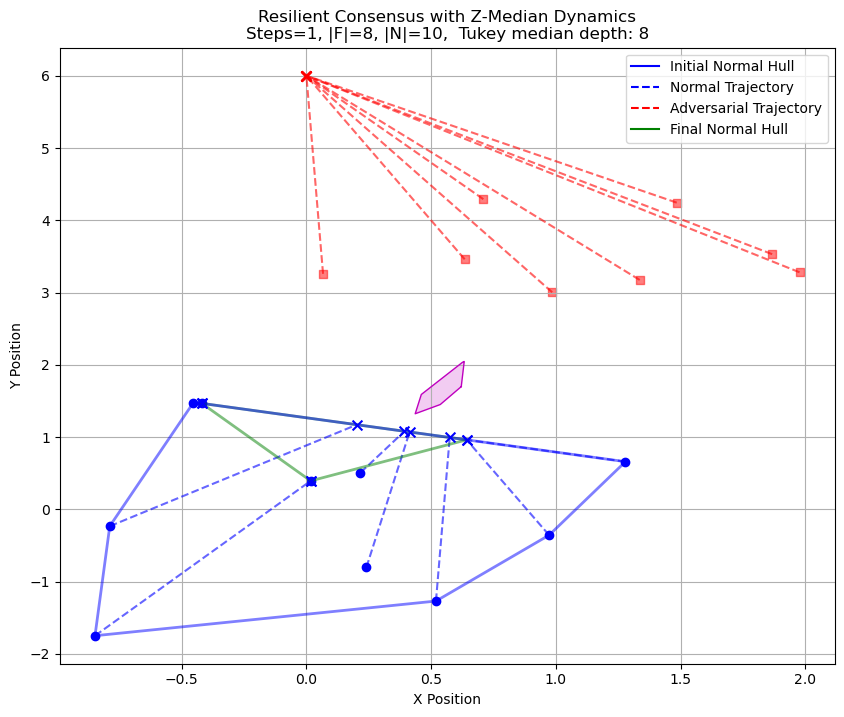

In [8]:
np.random.seed(52)
NUM_STEPS = 1
STEP_SIZE_HULL = 1
STEP_SIZE = 1


normal = 10
adversarial =8
n = normal+adversarial
#g1 = np.random.randn(int(normal/2), 2) *.8+np.array([-3,0])
#g2  =np.random.randn(int(normal/2), 2) *.8+np.array([3,0])
#N_nodes = np.vstack([g1,g2])
N_nodes = np.random.randn(normal, 2) *1 
#N_nodes = np.array(((-2,0),(0.5,0),(-1.5, 1),(3,-0.5),(1,0.3),(-1.5,.5)))
normal = len(N_nodes)
# Adversarial: 3 nodes starting slightly offset
F_nodes = np.random.randn(adversarial, 2) * .6 + np.array([1, 3.5]) 
#F_nodes = np.array(((0,3.5),(1.2,4),(-.6,3)))
adversarial = len(F_nodes)
# Target for adversaries 
adv_target = np.array(([0.0, 4.0],[0.0,6.0],[0,6.1]))

# History storage
history_N = [N_nodes.copy()]
history_F = [F_nodes.copy()]

# Simulation Loop

print(f"Starting Simulation: {len(N_nodes)} Normal vs {len(F_nodes)} Adversarial")

for t in range(NUM_STEPS):
    current_N = history_N[-1]
    current_F = history_F[-1]

    all_positions = np.vstack([current_N, current_F])
    # --- Update Normal Nodes ---
    #target[i] = []
    next_N = []

    next_N = update_resilient_layers(current_N, all_positions, STEP_SIZE,STEP_SIZE_HULL)

    next_F = []

    for i in range(len(current_F)):
        pos = current_F[i]
        #direction = adv_target[i] - pos
        #norm = np.linalg.norm(direction)
        #if norm > 0:
         #   move = (direction / norm) * STEP_SIZE * 4.5 # They move slightly faster
       # else:
           # move = np.zeros(2)
        #next_F.append(pos + move)
        next_F.append(pos+(adv_target[1]-pos)*STEP_SIZE)
       # next_F = update_resilient_layers(current_F, all_positions, STEP_SIZE)
    # Store
    history_N.append(np.array(next_N))
    history_F.append(np.array(next_F))
    

history_N = np.array(history_N) 
history_F = np.array(history_F) 

fig, ax = plt.subplots(figsize=(10, 8))

# Plot Trajectories
# Normal Nodes (Blue)
for i in range(history_N.shape[1]):
    ax.plot(history_N[:, i, 0], history_N[:, i, 1], 'b--', alpha=0.6)
    ax.scatter(history_N[-1, i, 0], history_N[-1, i, 1], c='blue', s=50, marker = 'x',zorder=5) # End
    ax.scatter(history_N[0, i, 0], history_N[0, i, 1], c='blue', alpha=1) # Start

# Adversarial Nodes (Red)
for i in range(history_F.shape[1]):
    ax.plot(history_F[:, i, 0], history_F[:, i, 1], 'r--', alpha=0.6)
    ax.scatter(history_F[-1, i, 0], history_F[-1, i, 1], c='red', s=50, marker='x', zorder=5) # End
    ax.scatter(history_F[0, i, 0], history_F[0, i, 1], c='red', marker='s', alpha=0.5) # Start
X= np.vstack([history_N[0], history_F[0]])
depth, poly = TukeyMed(X,False)
# Annotations
ax.set_title(f"Resilient Consensus with Z-Median Dynamics\nSteps={NUM_STEPS}, |F|={adversarial}, |N|={normal},  Tukey median depth: {depth}")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Plot convex hull of final and initial normal positions 

if len(history_N[-1]) >= 3:
    hull = ConvexHull(history_N[-1])
    for simplex in hull.simplices:
        ax.plot(history_N[-1, simplex, 0], history_N[-1, simplex, 1], 'g-', linewidth=2, alpha=0.5)
    hull2 = ConvexHull(history_N[0])
    for simplex in hull2.simplices:
        ax.plot(history_N[0, simplex, 0], history_N[0, simplex, 1], 'b-', linewidth=2, alpha=0.5)
# Legend dummy lines
ax.plot([],[],'b-', label = 'Initial Normal Hull')
ax.plot([],[], 'b--', label='Normal Trajectory')
ax.plot([],[], 'r--', label='Adversarial Trajectory')
ax.plot([],[], 'g-', label='Final Normal Hull')
ax.legend()

poly = np.vstack([poly, poly[0]])
plt.plot(poly[:,0], poly[:,1], 'm-', linewidth=1)
plt.fill(poly[:,0], poly[:,1], 'm', alpha=0.2)
plt.savefig("Zmed_example_1.jpg")           
plt.grid(True)
plt.show()

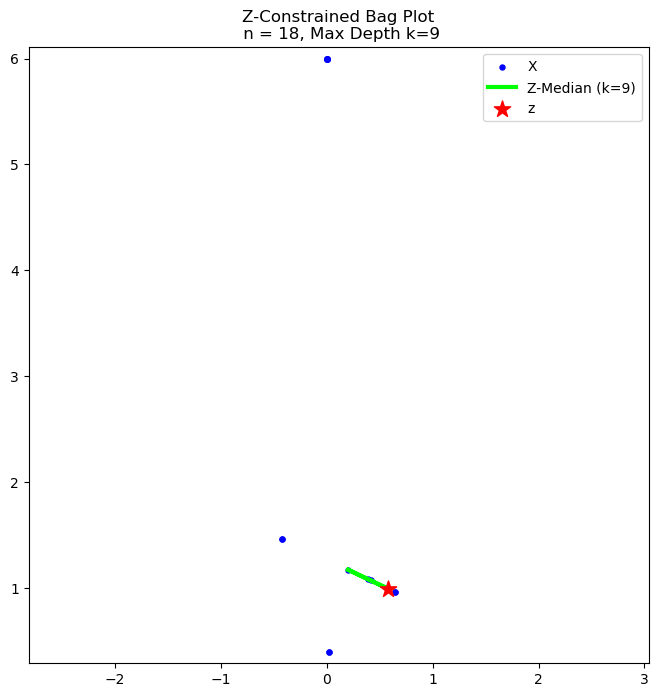

In [12]:
step = 1
X= np.vstack([history_N[step], history_F[step]])
#plot_robust_collapse_check(X, 0, 2)
ZBagPlot(X, 0)
#TukeyMed(X,True)

#PlotBoundedCells(X)
plt.show()

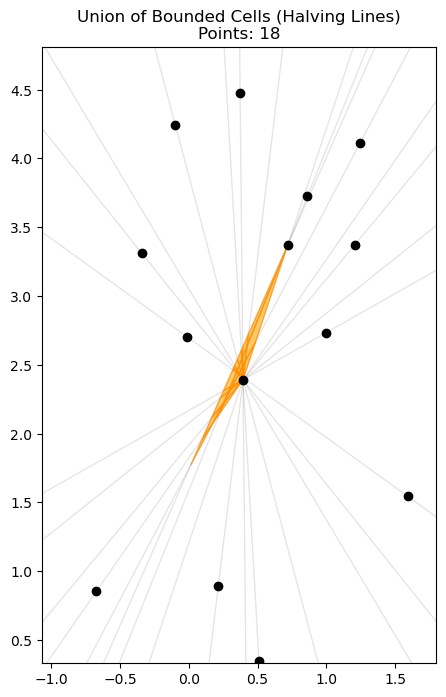

In [23]:
step = 0
X= np.vstack([history_N[step], history_F[step]])
PlotBoundedCells(X, ax=None)

In [28]:
diam0=0
diam1=0
for point1 in history_N[0]:
    for point2 in history_N[0]:
        dist = np.linalg.norm(point1-point2)
        if dist>diam0:
            diam0 = dist
for point1 in history_N[-1]:
    for point2 in history_N[-1]:
        dist = np.linalg.norm(point1-point2)
        if dist>diam1:
            diam1 = dist            
print(diam0)
print(diam1)

5.0899870979016315
0.7580234836486962


Running Simulation (300 steps)...
Generating Animation...
Saving to zbagplot_animation_mpl3.gif...
Done.


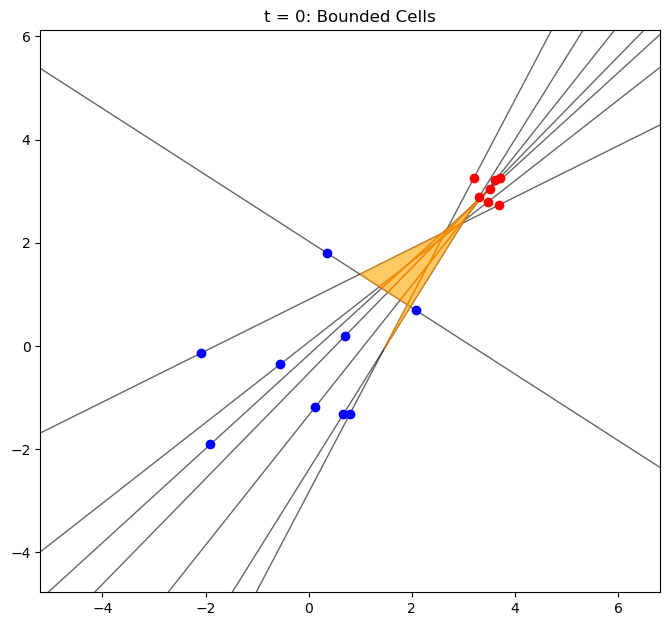

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import ConvexHull
from itertools import combinations

# Import your ZBagPlot function
# Assuming zbagplot.py is in the same directory. 
# If not, paste the ZBagPlot function here.


# --- 1. Core Functions (ZTukeyMed & Update Logic) ---


NUM_STEPS = 300
STEP_SIZE = 0.01

normal = 9
adversarial = 7 
n = normal + adversarial

N_nodes = np.random.randn(normal, 2) * 1
F_nodes = np.random.randn(adversarial, 2) *.2 + np.array([3.5, 3.0]) 

# History storage
history_N = [N_nodes.copy()]
history_F = [F_nodes.copy()]

# --- 3. Run Simulation Loop (Pre-calculate Data) ---
print(f"Running Simulation ({NUM_STEPS} steps)...")

for t in range(NUM_STEPS):
    current_N = history_N[-1]
    current_F = history_F[-1]
    all_positions = np.vstack([current_N, current_F])
    
    # Update Normal
    next_N = update_resilient_layers(current_N, all_positions, STEP_SIZE, STEP_SIZE*2)

    # Update Adversarial (Static for now based on your code)
    next_F = []
    for i in range(len(current_F)):
        next_F.append(current_F[i])
        
    history_N.append(np.array(next_N))
    history_F.append(np.array(next_F))

history_N = np.array(history_N)
history_F = np.array(history_F)

# --- 4. Animation using Matplotlib ---
print("Generating Animation...")

fig, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-4,4)
plt.ylim(-4,4)
# Define the frames we want (every 5th step)
plot_indices = range(0, NUM_STEPS + 1,3)

def update_plot(frame_idx):
    """
    Animation callback.
    frame_idx is the actual time step t from the simulation.
    """
    ax.clear() # Clear previous frame
    
    # Retrieve data for this step
    curr_N = history_N[frame_idx]
    curr_F = history_F[frame_idx]
    all_pos = np.vstack([curr_N, curr_F])
    
    # Agent 0 is the 0-th element of all_pos
    # ZBagPlot handles the plotting internally on the provided axis 'ax'
    # It sets titles, limits, and draws the bagplot.
    #max_k, _ = ZBagPlot(all_pos, 0, ax=ax, plot=True)
    faces = PlotBoundedCells(curr_N,curr_F,ax = ax)
    # We can override the title if we want to add the step count
    ax.set_title(f"t = {frame_idx}: Bounded Cells")
    #ax.set_xlim(-7,7)
    #ax.set_ylim(-7,7)
    if frame_idx == 0:
        plt.savefig("Zmed_bounded_cells_t0.png")
    if frame_idx == 300:
        plt.savefig("Zmed_bounded_cells_t300.png")
# Create Animation object
# frames iterator yields the specific steps (0, 5, 10...)
ani = animation.FuncAnimation(fig, update_plot, frames=plot_indices, interval=100)

# Save as GIF
output_file = "zbagplot_animation_mpl3.gif"
print(f"Saving to {output_file}...")
ani.save(output_file, writer='pillow', fps=5)

print("Done.")